In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

In [ ]:
mnist = MNIST(root = 'data', train = True, download = True, transform = Compose((ToTensor(), Normalize(mean = (0.5,), std  = (0.5,)))))

In [ ]:
img, label = mnist[0]
print('Label:', label)
print(img[:, 10:15, 10:15])

Label: 5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


In [ ]:
torch.min(img), torch.max(img)

(tensor(-1.), tensor(1.))

In [ ]:
def denorm(x):
   out = (x+1)/2 # spreads the data from -1-+1 range to 0-+1
   return out.clamp(0, 1)

Label: 5


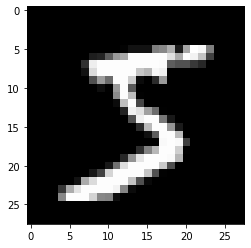

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap = 'gray')
print('Label:', label)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle = True)

first batch
torch.Size([100, 1, 28, 28])
tensor([3, 4, 4, 4, 8, 9, 9, 0, 2, 1, 9, 7, 5, 6, 2, 5, 7, 1, 4, 2, 3, 7, 2, 3,
        8, 4, 6, 2, 2, 0, 5, 3, 1, 2, 8, 8, 4, 1, 0, 8, 5, 7, 6, 0, 8, 9, 6, 8,
        2, 8, 9, 1, 7, 3, 7, 7, 4, 2, 7, 1, 6, 6, 4, 0, 1, 5, 2, 8, 6, 8, 3, 0,
        3, 6, 1, 6, 4, 0, 8, 8, 9, 1, 6, 9, 4, 5, 4, 3, 9, 2, 3, 6, 0, 9, 5, 3,
        9, 2, 5, 4])


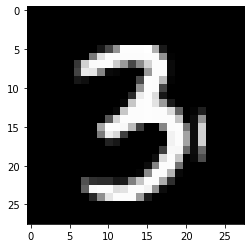

In [ ]:
for img_batch, label_batch in data_loader:
  print('first batch')
  print(img_batch.shape)
  plt.imshow(img_batch[0][0], cmap = 'gray')
  print(label_batch)
  break


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

Discriminator Network - try to classify the image as Real Or Generated
We can use CNN, but here we use a FNN. Each 28*28 image becomea vector of size 784

In [ ]:
image_size = 784
hidden_size = 256

In [ ]:
import torch.nn as nn
d = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid ()
)

Leaky ReLU - In ReLU we ignore all negative value, but in Leaky ReLU we multiply -ve numbers with the parameter inside the function. It is beacuse Leaky ReLU allows to pass a small gradient signal for the -ve signal to pass. Especially for training the generator. 

Output of the discriminator is a single no. b/w 0 & 1.

In [ ]:
d.to(device); # we will we moving the disciminator to the GPU

In [ ]:
d

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

Generator Network

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. Once again, to keep things simple, we'll use a feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 px image.

In [ ]:
latent_size = 64 # input size to generator, each of the 64 dimensions carry different characters  

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

The activation function that we are going to use is tanh, hyperbolic tanh function takes input and return output values from -1 to + 1 and denormalize them as images

In [ ]:
G

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [ ]:
y = G(torch.randn(2, latent_size)) # create a batch of 2 latent vectors and it is passed into the genrators
# and is ued to generate 2 images
y.shape

torch.Size([2, 784])

In [ ]:
gen_imgs = denorm(y.reshape((-1, 28, 28)).detach()) #detach is used to return a new tensor, instead of giving any gradients associated with it.

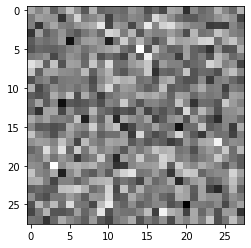

In [ ]:
plt.imshow(gen_imgs[0], cmap = 'gray')

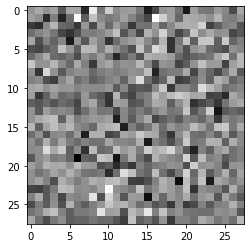

In [ ]:
plt.imshow(gen_imgs[1], cmap = 'gray')

Output of the generator is basically random noise

In [ ]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

Discriminator Training

We use binary cross entropy loss function

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(d.parameters(), lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)

In [ ]:
def reset_grad():
  d_optimizer.zero_grad() # at the end of every gradient descent iteration we have to reset the gradients back to 0
  g_optimizer.zero_grad()

def train_discriminator(images):
  #create the labels which are later used as input for the BCE loss
  real_labels = torch.ones(batch_size, 1).to(device)
  fake_labels = torch.zeros(batch_size, 1).to(device)

  # loss for real images
  outputs = d(images)
  d_loss_real = criterion(outputs, real_labels)
  real_score = outputs # real_labels are ones

   # loss for fake images

  z = torch.randn(batch_size, latent_size).to(device) # creating a batch of fake images, we generate a 100 latent veactors and move to the device
  fake_images = G(z) # give 100 fake images
  outputs = d(fake_images)
  d_loss_fake = criterion(outputs, fake_labels)# we want the discriminator to give back 0 
  fake_score = outputs

  # combine losses
  d_loss = d_loss_real + d_loss_fake

  #reset gradients
  reset_grad()

  #compute gradients
  d_loss.backward()

  # adjust the parameters using backprop
  d_optimizer.step()

  return d_loss, real_score, fake_score







 


Here are the steps involved in training the discriminator.

We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated.

We first pass a batch of real images, and compute the loss, setting the target labels to 1.

Then, we generate a batch of fake images using the generator, pass them into the discriminator, and compute the loss, setting the target labels to 0.

Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (d_optimizer only affects the D.parameters())

GENERATOR TRAINING

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

We generate a batch of images using the generator, pass the into the discriminator.

We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images

In [ ]:
def train_generator():
  # we pass the random batch of latent vector to the generator model, at that time we geta  batch of fake
  # images
  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  labels = torch.ones(batch_size, 1).to(device)
  # we put the fake images into the discriminator, here we are not training the
  # discriminator, that discriminator will give out probabilities
  g_loss = criterion(d(fake_images), labels)

  # backpropagation and optimize

  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  return g_loss, fake_images

  # generators job is to fool the discriminator, discriminator must give out values a s close 
  # to 1, such that parametres of generators must change such that discriminator must 
  # images are real
  # for fake images our labels were 0, and generators our labels were set to 1
  # such that generator could generate such an image that even discriminator will not be able to identify



Training the Model

In [ ]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

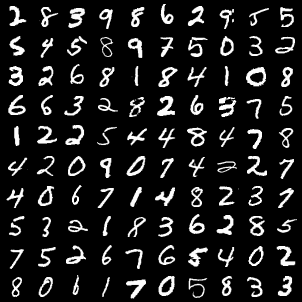

In [ ]:
# saving  a batch of real images, that is used for comparing with the generated images
from IPython.display import Image
from torchvision.utils import save_image

#saving some real images

for images, _ in data_loader:
  images = images.reshape(images.size(0), 1, 28, 28)
  save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)

Image(os.path.join(sample_dir, 'real_images.png'))

We define a function to save a batch of generated images at the end of each epoch. We use a fixed set of input vectors to the generator to see the images generated.


saving fake_images-0000.png


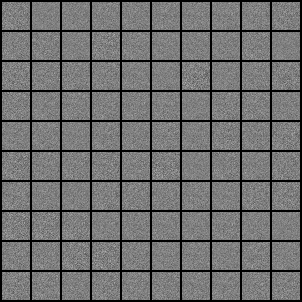

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index): # index is the epoch no
  fake_images = G(sample_vectors)
  fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
  fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
  print('saving', fake_fname)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 10)

#Before Training
save_fake_images(0)# one batch of output from the generator, output is just random
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

Training the model - First we train the discriminator, then the generator

In [ ]:
  %%time
  
  num_epochs = 50
  total_steps = len(data_loader) # 600 steps in each epoch or 600 images in each batch
  
  d_losses, g_losses, real_scores, fake_scores = [], [], [], []

  for epoch in range(num_epochs): #we iterate over the dataloader and it gives us batches of data, we neglect the labels
    for i, (images, _) in enumerate(data_loader):
      # Load a batch & transform to vectors
      images = images.reshape(batch_size, -1).to(device)

      # Training the discriminator and generator

      d_loss, real_score, fake_score = train_discriminator(images)
      g_loss, fake_images = train_generator()

      #Inspect the losses
      if (i+1)% 200 == 0: # at 200th step in each epoch we print out epoch, losses etc
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        real_scores.append(real_score.mean().item())
        fake_scores.append(fake_score.mean().item())
        print('Epoch[{}/{}], Step[{}/{}, d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
              .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
        # sample $ save image
        save_fake_images(epoch+1)

Epoch[0/50], Step[200/600, d_loss: 0.0447, g_loss: 3.9305, D(x): 0.99, D(G(z)): 0.04
saving fake_images-0001.png
Epoch[0/50], Step[400/600, d_loss: 0.0675, g_loss: 5.5933, D(x): 0.98, D(G(z)): 0.04
saving fake_images-0001.png
Epoch[0/50], Step[600/600, d_loss: 0.0916, g_loss: 5.5826, D(x): 0.98, D(G(z)): 0.06
saving fake_images-0001.png
Epoch[1/50], Step[200/600, d_loss: 0.0511, g_loss: 4.5893, D(x): 0.99, D(G(z)): 0.04
saving fake_images-0002.png
Epoch[1/50], Step[400/600, d_loss: 0.4796, g_loss: 4.1814, D(x): 0.83, D(G(z)): 0.08
saving fake_images-0002.png
Epoch[1/50], Step[600/600, d_loss: 0.9019, g_loss: 4.0090, D(x): 0.73, D(G(z)): 0.09
saving fake_images-0002.png
Epoch[2/50], Step[200/600, d_loss: 0.1716, g_loss: 5.6662, D(x): 0.97, D(G(z)): 0.12
saving fake_images-0003.png
Epoch[2/50], Step[400/600, d_loss: 0.1557, g_loss: 3.9467, D(x): 0.95, D(G(z)): 0.09
saving fake_images-0003.png
Epoch[2/50], Step[600/600, d_loss: 0.7014, g_loss: 3.0766, D(x): 0.79, D(G(z)): 0.29
saving fake

Initially we make some fake images & comapare it with original ones. 
Then we train disciminator to classify b/w original one & generated one
then we tell the generator to get better, and the process continues. The model will get better over after going through each epoch 

In [ ]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(d.state_dict(), 'D.ckpt')

Converting Images to Video

In [ ]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

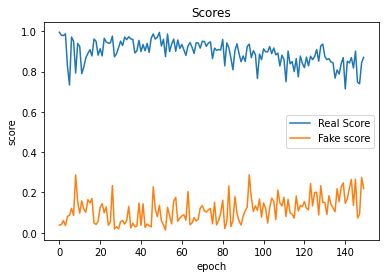

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');# we need real score and fake score to get closer as much as possible, because
#w e need a great generator 

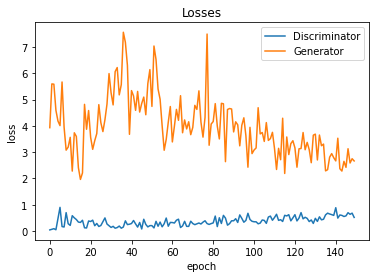

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');